In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !export PYTHONPATH=/Users/piyush/projects/ViDA-SSL/
import sys
sys.path.append("/Users/piyush/projects/ViDA-SSL/")

In [3]:
from os.path import join
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.special import softmax

import torch
import torch.nn.functional as F
from fast_pytorch_kmeans import KMeans
from transformers import AutoTokenizer, AutoModel

from misc.local_utils import get_phrase_embedding, get_sentence_embedding
from utils.viz import bokeh_2d_scatter, bokeh_2d_scatter_new
from datasets.ntu import NTU
from datasets.epic import EPIC
from datasets.something_something import SomethingSomething
from datasets.finegym import FineGym
from datasets.ucf import UCF
from datasets.kinetics import Kinetics

### Load datasets

In [4]:
datasets = [
    {
        "name": "Kinetics",
        "args": {"data_dir": "../../data/Kinetics-400/"},
        "color": "limegreen",
        "filename": "kinetics_400_labels.csv",
    },
    {
        "name": "UCF",
        "args": {"data_dir": "../../data/UCF-101/"},
        "color": "red",
        "filename": "classes_cleaned.txt",
    },
    {
        "name": "NTU",
        "args": {"data_dir": "../../data/NTU/"},
        "color": "blue",
        "filename": "class_labels.txt",
    },
    {
        "name": "SomethingSomething",
        "args": {"data_dir": "../../data/Something-Something/"},
        "color": "yellow",
        "filename": "fine_grained_classes_cleaned.csv",
    },
    {
        "name": "FineGym",
        "args": {"data_dir": "../../data/FineGym/"},
        "color": "gray",
        "filename": "gym99_categories_cleaned.txt",
    },
    {
        "name": "EPIC",
        "args": {"data_dir": "../../data/EPIC-KITCHENS-100/"},
        "color": "magenta",
        "filename": "EPIC_100_verb_classes.csv",
    },
]

In [5]:
# load class labels per dataset
dataset_action_labels = dict()

for dataset_args in datasets:
    dataset = eval(f"{dataset_args['name']}(**{dataset_args['args']})")
    class_label_dict = dataset._load_annotations(filename=dataset_args["filename"])
    dataset_action_labels[dataset_args['name']] = class_label_dict

### Get action class embeddings

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

/Users/piyush/miniforge3/envs/video/lib/python3.9/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a Be

In [7]:
dataset_action_embeddings = dict()

for dataset, action_labels in dataset_action_labels.items():
    dataset_action_embeddings[dataset] = {
        # k: get_sentence_embedding(model, tokenizer, v) \
        k: get_phrase_embedding(model, tokenizer, v) \
        for k, v in tqdm(action_labels.items(), desc=f"Extracting BERT embeddings for {dataset}")
    }

Extracting BERT embeddings for NTU: 100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.14it/s]
Extracting BERT embeddings for SomethingSomething: 100%|██████████████████████████████████████████████████████████████████| 174/174 [00:10<00:00, 16.82it/s]
Extracting BERT embeddings for EPIC: 100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:04<00:00, 22.41it/s]


### Visualize embeddings

In [64]:
dfs = []
all_embeddings = []

for datadict in datasets:
    local_df = pd.DataFrame(None)
    
    class_embeddings = dataset_action_embeddings[datadict["name"]]
    class_embeddings = torch.stack(list(class_embeddings.values()))
    action_labels = dataset_action_labels[datadict["name"]]
    
    local_df["class_id"] = list(action_labels.keys())
    local_df["class_label"] = list(action_labels.values())
    local_df["color"] = datadict["color"]
    local_df["dataset"] = datadict["name"]
    dfs.append(local_df)
    
    all_embeddings.append(class_embeddings)

In [65]:
embeddings = torch.cat(all_embeddings)
(U, S, V) = torch.pca_lowrank(embeddings)

K = 2

all_dimreds = []
dataset_action_latents = dict()

for i, X in enumerate(all_embeddings):
    Z = torch.matmul(X, V[:, :K])

    dataset_action_latents[datasets[i]["name"]] = {dfs[i].loc[j, "class_id"]: Z[j] for j in range(Z.shape[0])}
    
    try:
        dfs[i]["Z1"] = Z[:, 0]
        dfs[i]["Z2"] = Z[:, 1]
    except:
        import ipdb; ipdb.set_trace()

In [66]:
all_df = pd.concat(dfs)

In [67]:
all_df.head().shape

(5, 6)

In [68]:
all_df.head()

,class_id,class_label,color,dataset,Z1,Z2
0,0,abseiling,limegreen,Kinetics,4.897441,7.948718
1,1,air drumming,limegreen,Kinetics,22.006836,6.697647
2,2,answering questions,limegreen,Kinetics,23.550903,4.299633
3,3,applauding,limegreen,Kinetics,8.714595,2.982089
4,4,applying cream,limegreen,Kinetics,18.522312,-1.956608


In [69]:
bokeh_2d_scatter_new(
    df=all_df, x="Z1", y="Z2", hue="dataset", label="class_label", use_nb=True, color_column="color",
    title="BERT-based embeddings for action classes (phrases) in various datasets.", legend_loc="top_right",
)

Loading BokehJS ...

### Visualize embeddings per dataset

In [14]:
def plot_dataset_embeddings(dataset_name, action_labels, embeddings_dict, color="blue", K=2):
    embeddings = torch.stack(list(embeddings_dict.values()))
    (U, S, V) = torch.pca_lowrank(embeddings)
    Z = torch.matmul(embeddings, V[:, :K])

    local_df = pd.DataFrame(None)
    local_df["class_id"] = list(action_labels.keys())
    local_df["class_label"] = list(action_labels.values())
    local_df["color"] = color
    local_df["dataset"] = dataset_name
    local_df["Z1"] = Z[:, 0]
    local_df["Z2"] = Z[:, 1]

    bokeh_2d_scatter_new(
        df=local_df, x="Z1", y="Z2", hue="dataset", label="class_label", use_nb=True, color_column="color",
        title=f"BERT-based embeddings for action classes (phrases) in {dataset_name}.", legend_loc="top_right",
    )

In [15]:
dataset = "SomethingSomething"

idx = [x["name"] for x in datasets].index(dataset)
color = datasets[idx]["color"]

plot_dataset_embeddings(dataset, dataset_action_labels[dataset], dataset_action_embeddings[dataset])

Loading BokehJS ...

In [ ]:
action_labels = dataset_action_labels["SomethingSomething"]
embeddings_dict = dataset_action_embeddings["SomethingSomething"]

embeddings = torch.stack(list(embeddings_dict.values()))

In [ ]:
embeddings.shape

In [ ]:
(U, S, V) = torch.pca_lowrank(embeddings)
Z = torch.matmul(embeddings, V[:, :2])

In [ ]:
Z.shape

In [ ]:
local_df = pd.DataFrame(None)
local_df["class_id"] = list(action_labels.keys())
local_df["class_label"] = list(action_labels.values())
local_df["color"] = "yellow"
local_df["dataset"] = "SomethingSomething"

local_df["Z1"] = Z[:, 0]
local_df["Z2"] = Z[:, 1]

In [ ]:
bokeh_2d_scatter_new(
    df=local_df, x="Z1", y="Z2", hue="dataset", label="class_label", use_nb=True, color_column="color",
    title="BERT-based embeddings for action classes (phrases) in various datasets.", legend_loc="top_right",
)

### Compute overlap for every `target` dataset w.r.t. `source` dataset

In [16]:
def compute_label_similarity(source: dict, target: dict, threshold: float = 0.1):
    df = pd.DataFrame(None, index=list(source.keys()), columns=list(target.keys()), dtype=float)

    source_embeddings = torch.stack([v for k, v in source.items()])
    target_embeddings = torch.stack([v for k, v in target.items()])
    
    for i in range(len(source_embeddings)):
        df.iloc[i] = F.cosine_similarity(target_embeddings, source_embeddings[[i], :]).numpy()
    
    return df

In [46]:
def compute_label_distance(source: dict, target: dict, threshold: float = 0.1, p=1):
    df = pd.DataFrame(None, index=list(source.keys()), columns=list(target.keys()), dtype=float)

    source_embeddings = torch.stack([v for k, v in source.items()])
    target_embeddings = torch.stack([v for k, v in target.items()])
    
    for i in range(len(source_embeddings)):
        df.iloc[i] = F.pairwise_distance(target_embeddings, source_embeddings[[i], :], p=p).numpy()
    
    return df

In [47]:
def compute_metric_per_dataset(dataset, metric=compute_label_similarity):
    df = metric(dataset_action_embeddings[dataset], dataset_action_embeddings[dataset])
    df = df.rename(columns=dataset_action_labels[dataset], index=dataset_action_labels[dataset])

0.0 1.0 0.8711898144760297
0.0 1.0 0.7816329565713206
0.0 1.0 0.7191662394500044
0.0 1.0 0.11163789812472384
0.0 1.0 0.46661090542636746
0.0 1.0 0.7556620420785133


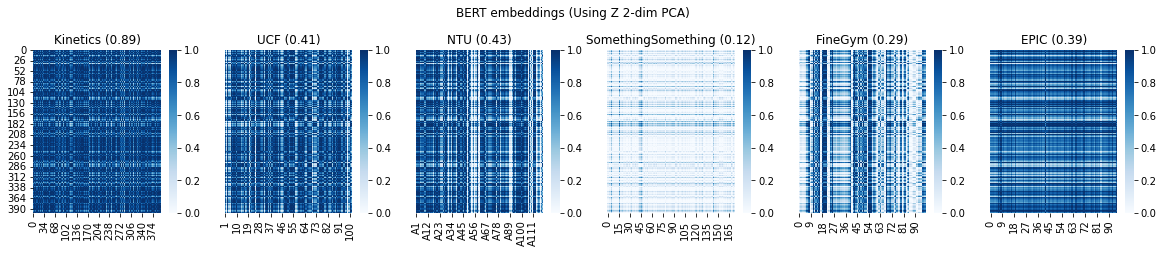

In [81]:
dataset_label_overlap = pd.DataFrame(None, index=["Kinetics"], columns=dataset_action_embeddings.keys())

fig, axes = plt.subplots(1, len(dataset_action_embeddings), figsize=(20, 3))

norm_dfs = dict()

i = 0
for key in dataset_action_embeddings:
    # df = compute_label_distance(dataset_action_embeddings["Kinetics"], dataset_action_embeddings[key])
    df = compute_label_similarity(dataset_action_latents["Kinetics"], dataset_action_latents[key])
    # import ipdb; ipdb.set_trace()
    # df.iloc[:, :] = softmax(df.values, axis=0)
    df = (df - df.min()) / (df.max() - df.min())
    # df = 1-df

    overlap = np.linalg.norm(df.values) / df.shape[0]
    # overlap = df.mean().mean()
    print(df.min().min(), df.max().max(), df.mean().mean())
    dataset_label_overlap.loc["Kinetics", key] = overlap

    ax = axes[i]
    sns.heatmap(df, ax=ax, cmap="Blues")
    ax.set_title(f"{key} ({overlap:.2f})")
    
    if i > 0:
        ax.set_yticks([])
    i += 1
    
    df = df.rename(columns=dataset_action_labels[key], index=dataset_action_labels["Kinetics"])

plt.suptitle("BERT embeddings (Using Z 2-dim PCA)", y=1.08)
plt.show()

In [27]:
df = compute_label_distance(dataset_action_embeddings["UCF"], dataset_action_embeddings["UCF"])
df = df.rename(columns=dataset_action_labels["UCF"], index=dataset_action_labels["UCF"])

In [28]:
norm_df = (df - df.min()) / (df.max() - df.min())

In [29]:
df.mean().mean()

52.63733786711576

In [30]:
norm_df.mean().mean()

0.7328262247819327

In [31]:
norm_df.max().max(), norm_df.min().min()

(1.0, 0.0)

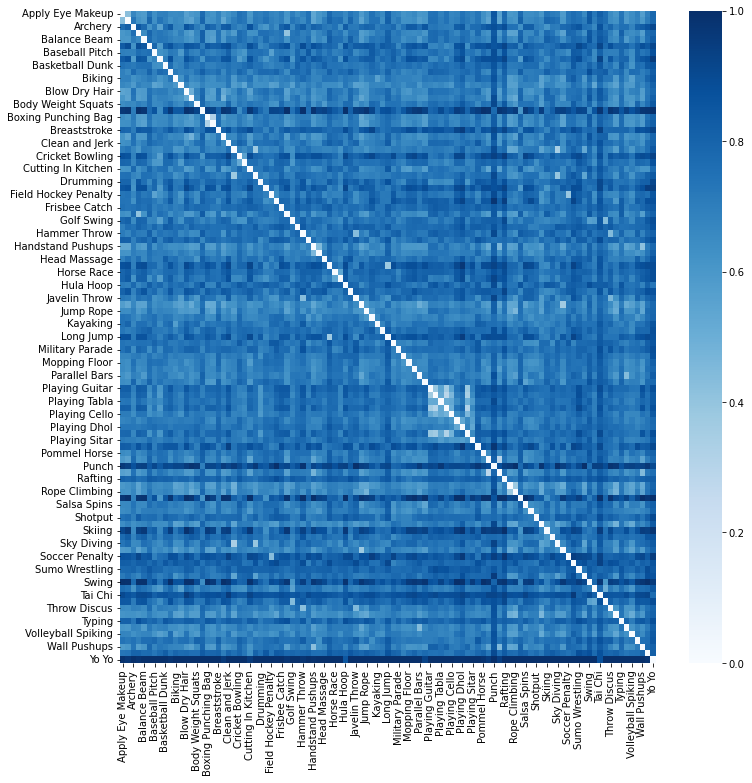

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(norm_df, ax=ax, cmap="Blues", vmin=0.0, vmax=1.0)

plt.show()

In [33]:
df = compute_label_distance(dataset_action_embeddings["NTU"], dataset_action_embeddings["NTU"])
df = df.rename(columns=dataset_action_labels["NTU"], index=dataset_action_labels["NTU"])

In [34]:
norm_df = (df - df.min()) / (df.max() - df.min())

In [35]:
df.mean().mean(), norm_df.mean().mean()

(50.27037151449706, 0.7332932732884411)

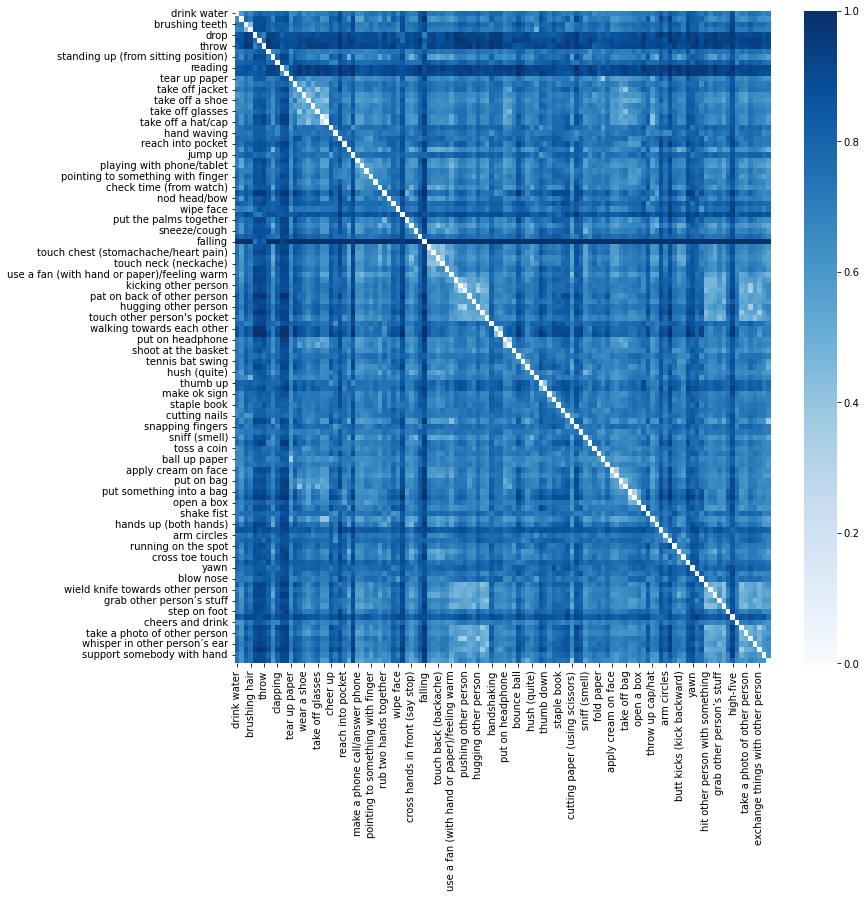

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(norm_df, ax=ax, cmap="Blues", vmin=0.0, vmax=1.0)

plt.show()

In [ ]:
df = compute_label_similarity(dataset_action_embeddings["SomethingSomething"], dataset_action_embeddings["SomethingSomething"])
df = df.rename(columns=dataset_action_labels["SomethingSomething"], index=dataset_action_labels["SomethingSomething"])

In [ ]:
norm_df = (df - df.min()) / (df.max() - df.min())

In [ ]:
df.mean().mean(), norm_df.mean().mean()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(norm_df, ax=ax, cmap="Blues", vmin=0.0, vmax=1.0)

plt.show()

In [ ]:
dataset_action_embeddings.keys()

In [ ]:
df = compute_label_similarity(dataset_action_embeddings["Kinetics"], dataset_action_embeddings["SomethingSomething"])
df = df.rename(index=dataset_action_labels["Kinetics"], columns=dataset_action_labels["SomethingSomething"])

In [ ]:
norm_df = (df - df.min()) / (df.max() - df.min())

In [ ]:
df.mean().mean(), norm_df.mean().mean()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(norm_df, ax=ax, cmap="Blues", vmin=0.0, vmax=1.0)

plt.show()

### Junk code

In [ ]:
action_labels = dataset_action_labels["NTU"]
embeddings_dict = dataset_action_embeddings["NTU"]

embeddings = torch.stack(list(embeddings_dict.values()))

In [ ]:
embeddings.shape

In [ ]:
(U, S, V) = torch.pca_lowrank(embeddings)
Z = torch.matmul(embeddings, V[:, :2])

In [ ]:
Z.shape

In [ ]:
local_df = pd.DataFrame(None)
local_df["class_id"] = list(action_labels.keys())
local_df["class_label"] = list(action_labels.values())
local_df["color"] = "blue"
local_df["dataset"] = "NTU"

local_df["Z1"] = Z[:, 0]
local_df["Z2"] = Z[:, 1]

In [ ]:
bokeh_2d_scatter_new(
    df=local_df, x="Z1", y="Z2", hue="dataset", label="class_label", use_nb=True, color_column="color",
    title="BERT-based embeddings for action classes (phrases) in various datasets.", legend_loc="top_right",
)

In [ ]:
action1 = "take off a hat/cap"
action2 = "falling"

for k, v in dataset_action_labels["NTU"].items():
    if v == action1:
        a1_idx = k
    if v == action2:
        a2_idx = k

In [ ]:
a2_idx, a1_idx

In [ ]:
Z[20]

In [ ]:
Z[42]

In [ ]:
dataset_action_labels["NTU"]["A21"]

In [ ]:
F.pairwise_distance(
    dataset_action_embeddings["NTU"][a1_idx].unsqueeze(0), dataset_action_embeddings["NTU"][a2_idx].unsqueeze(0)
)

In [ ]:
F.pairwise_distance(
    Z[20].unsqueeze(0), Z[42].unsqueeze(0)
)